In [1]:
from types import SimpleNamespace
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim
from dataset import get_mnist
from networks import RealNVP

In [2]:
args = SimpleNamespace()
args.image_size = (1, 28, 28)
args.input_dim = np.prod(args.image_size)
args.hidden_dim = 512
args.num_layer = 6
args.lr = 1e-4
args.batch = 512
args.epoch = 150
args.ratio = 0.8
args.device = "cuda" if torch.cuda.is_available() else "cpu"
print(args)

namespace(image_size=(1, 28, 28), input_dim=784, hidden_dim=512, num_layer=6, lr=0.0001, batch=512, epoch=150, ratio=0.8, device='cuda')


In [3]:
loader = get_mnist(args.batch, args.ratio)
model = RealNVP(args.image_size, args.input_dim, args.hidden_dim, args.num_layer, args.device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
history = SimpleNamespace(train_loss=[], valid_loss=[])
for _ in tqdm(range(args.epoch)):
    model.train()
    train_loss = 0
    for x, _ in loader.train: 
        optimizer.zero_grad()
        log_prob = model.log_prob(x.to(args.device))
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    history.train_loss.append(train_loss/len(loader.train))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for x, _ in loader.valid:
            log_prob = model.log_prob(x.to(args.device))
            loss = -log_prob.mean()
            
            valid_loss += loss.item()
    
    history.valid_loss.append(valid_loss/len(loader.valid))     

100%|██████████| 150/150 [39:02<00:00, 15.62s/it]


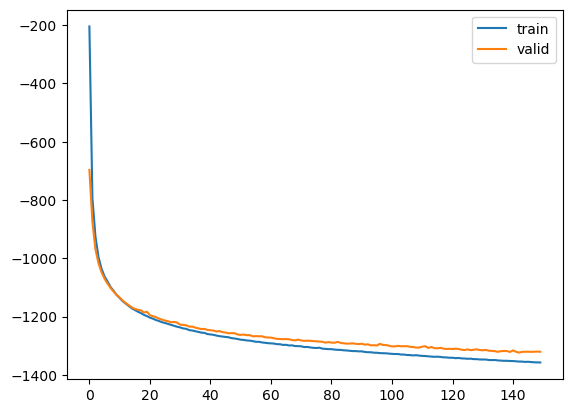

In [4]:
plt.plot(history.train_loss, label="train")
plt.plot(history.valid_loss, label="valid")
plt.legend()
plt.show()

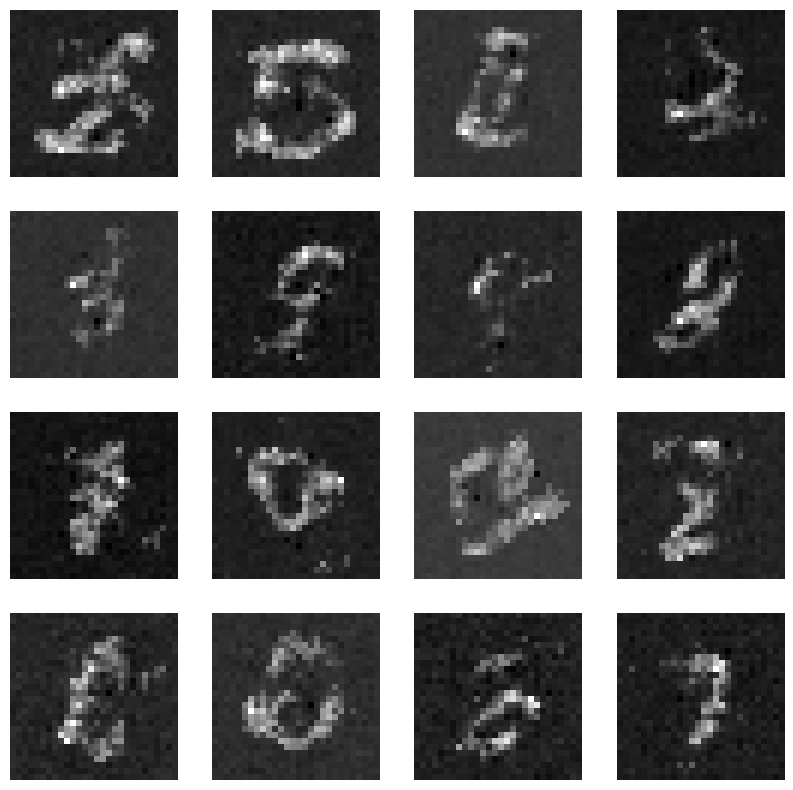

In [5]:
samples = model.sampling(16)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
plt.show()